# Numerical Optimization & Large Scale Linear Algebra
## Assignment 2: Classification of Handwritten Digits (using SVD)

---

> Kostis Konstantinos (p3352311) <br>
> MSc Data Science (Part-Time) <br>
> Athens University Of Economics and Business<br>

### Importing needed libraries

In [1]:
from sklearn.decomposition import TruncatedSVD
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
%matplotlib inline

# ignore warning messages
import warnings
warnings.filterwarnings('ignore') 

### Setting a seed for reproducibility

In [2]:
seed = 202405
np.random.seed(seed)

### Loading and transforming the data

In [3]:
xlsx_data_file = pd.ExcelFile('data.xlsx')
train_images_df = pd.read_excel(xlsx_data_file, 'azip', header=None)
train_digits_df = pd.read_excel(xlsx_data_file, 'dzip', header=None)
test_images_df = pd.read_excel(xlsx_data_file, 'testzip', header=None)
test_digits_df = pd.read_excel(xlsx_data_file, 'dtest', header=None)

In [4]:
# Post-Process the data
train_X = train_images_df.T.to_numpy()
train_y = train_digits_df.to_numpy()[0]

test_X = test_images_df.T.to_numpy()
test_y = test_digits_df.to_numpy()[0]

### Inspecting digits distribution

In [5]:
print('Training instances: {}'.format(len(train_y)))
pd.Series(train_y).value_counts()

Training instances: 1707


0    319
1    252
2    202
7    166
6    151
8    144
9    132
3    131
4    122
5     88
Name: count, dtype: int64

**Remarks**

- Class `0` has the most representative examples. 319 out of 1707
- Class `5` has the lowest number of representatives. 88 out of 1707. Lets hope this will not cause issues when trying to learn how a `5` looks like, although we might not do
  as good as on the other digits due to under-representation.

### Helper classes for reusability and problem framing

- `DigitSVDExtractor`: Is a class responsible for running SVD on the images of a specific digit-class, and mining `k` singular values and vectors.
- `SVDClassifier`: Is a class responsible for fiting the whole train set, using the `DigitSVDExtractor` per class.
  It allows for configuring k (the number of principal components) per class. It also contains functionality with respect to
  performing evaluation on a test set and plotting performance (e.g Accuracy) results.

**Note:**

The method used for SVD here, is based on Scikit-Learn Truncated SVD where the solver is the randomized algorithm!\
It may worth to compare this with Numpy's linalg SVD which does not perform the randomized algorithm. But the comparison
will not be addressed in this exercise.

Resources:

- [Scikit-Learn Truncated SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)
- [Numpy Linalg SVD](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html)

In [6]:
class DigitSVDExtractor:
    """ DigitSVDExtractor

    This class is responsible to extract k principal
    components for a set of images of a specific class.

    Args:
        - class_digit: Integer. Represents the digit.
        - k: Integer. The number of singular components to keep.(Default: 5)
        - n_iter: Integer. The number of iterations for the SVD solver (default: 10)
    """

    def __init__(self, class_digit, k=5, n_iter=10, seed=seed):
        self.class_digit = class_digit
        self.k = k
        self.n_iter = n_iter
        self.seed = seed

    def fit(self, X):
        """ Fit on X 

        Args:
            - X: Matrix containing vectors that represent a specific digit.
        """
        svd = TruncatedSVD(n_components=self.k, n_iter=self.n_iter,
                           random_state=self.seed)
        svd.fit(X)
        self.singular_vectors = svd.components_
        self.singular_values = svd.singular_values_

        return self

    def relative_residual(self, x, use_only_first=False) -> float:
        """ The method computes the relative residual.
        
        The method performs projection of x onto the class basis.
        Then, it reconstructs an approximation of x using the class basis.
        The residual vector (residual image) is computed via subtraction.
        Finally, the relative residual is computed.

        Args:
            x: ndarray, The input test image
            use_only_first: Boolean If true it only uses the first singular vector
              for computations
        """
        basis = None

        if use_only_first is True:
            basis = self.singular_vectors[0].reshape((1, -1))
        else:
            basis = self.singular_vectors

        projected_image = basis @ x
        reconstructed_image = basis.T @ projected_image
        residual_vector = x - reconstructed_image
        relative_residual = np.linalg.norm(residual_vector) / np.linalg.norm(x)

        return relative_residual

In [7]:
class SVDClassifier:
    def __init__(self, k=[5], n_iter=10, seed=seed):
        self.k = k
        self.n_iter = n_iter
        self.seed = seed

        # Per digit-class extractor using SVD
        self.digit_extractors = {}

    def fit(self, X, y):
        """ Fit on images.

        Extracts singular vectors and values per class/digit.
        """
        # Get the unique labels/digits
        y_unique = np.unique(y)

        # Replicate the number of components to use for every class
        if len(self.k) == 1:
            k_values = np.array(self.k * len(y_unique))
        else:
            k_values = np.array(self.k)

        for class_digit in y_unique:
            indices = (y == class_digit)
            class_images = X[indices]

            extractor = DigitSVDExtractor(class_digit, k=k_values[class_digit],
                                          n_iter=self.n_iter, seed=self.seed)
            extractor.fit(class_images)
            self.digit_extractors[class_digit] = extractor

        return self

    def predict(self, dataset_X):
        """ Predict on images. 
        
        Returns a predicted class/digit per given image.
        """
        predicted_digits = []

        for i in range(len(dataset_X)):
            test_image = dataset_X[i]

            class_residuals = []

            for class_digit in list(self.digit_extractors.keys()):
                relative_residual = self.digit_extractors[class_digit].relative_residual(test_image)
                class_residuals.append(relative_residual)

            class_residuals = np.array(class_residuals)
            # predict the digit by selecting the class with the smallest relative residual
            predicted_digit = np.argmin(class_residuals)
            predicted_digits.append(predicted_digit)

        predicted_digits = np.array(predicted_digits)

        return predicted_digits

    def evaluate(self, dataset_X, dataset_y):
        """ Calculates accuracy on a given dataset. """
        predicted_digits = self.predict(dataset_X)
        accuracy = (predicted_digits == dataset_y).sum() / len(dataset_y)

        return (accuracy, predicted_digits)

### 1. Learning the class digit representative matrices & computing and graphing accuracy on test set

**Methodology**

Using the **SVDClassifier** we can fit the training data for values of k in range (5, 20). \
On every choice of k we will evaluate the svd classifier, using the test set and computing the accuracy of the classifier
based on the relative residual measure. \
Finally we plot accuracy with respect to number of basis vectors.


In [8]:
accuracy_df = pd.DataFrame(columns=['n_components', 'accuracy'])
predictions_map = {}

for k in range(5, 21):
    svd_classifier = SVDClassifier(k = [k])
    svd_classifier.fit(train_X, train_y)
    (accuracy, predictions) = svd_classifier.evaluate(test_X, test_y)
    accuracy_df = pd.concat([accuracy_df, pd.DataFrame([{'n_components': k, 'accuracy': accuracy}])],
                            ignore_index=True)
    predictions_map[k] = predictions

In [9]:
accuracy_df

,n_components,accuracy
0,5,0.902840
1,6,0.905331
2,7,0.916791
3,8,0.920279
4,9,0.926258
5,10,0.931739
6,11,0.932237
7,12,0.935725
8,13,0.936223
9,14,0.939213


<Axes: title={'center': 'Accuracy of digits classification vs number of basis vectors'}, xlabel='n_components'>

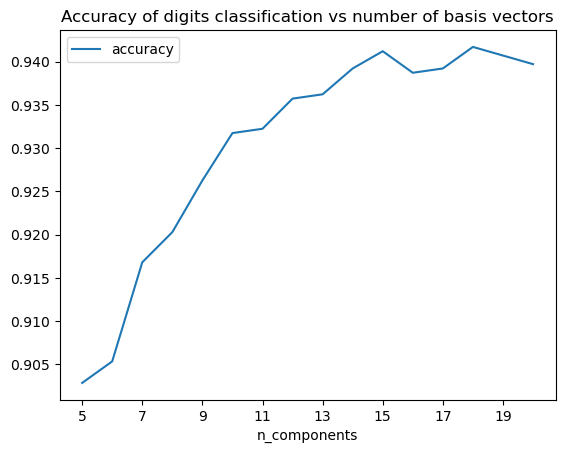

In [10]:
accuracy_df.plot(x='n_components', y='accuracy', title='Accuracy of digits classification vs number of basis vectors')

**Remarks**

The accuracy ranges from 0.90 (k=5) up to 0.94 (k=15). \
Tuning for accuracy, we would choose a k with the highest performance. Candidates include k=15 reaching 0.941206 and k=18 reaching 0.941704.\
Both are great performances, but we could use k=15 for computational efficiency (less memory).

### 2. Checking if all digits are equally easy or difficult to classify

**Methodology**

For k=5 (since it is a good baseline) we create a classification report (using Scikit-Learn) to understand the per class precision, recall and F1 measures.\
This report will help in understanding how easy or difficult it is to classify certain digits.\
Also a set of helper methods is created, to help visualize a grid of images (see the class **PlotUtils**)

In [11]:
class PlotUtils:

    @staticmethod
    def image2d(image_vector):
        n = int(np.sqrt(len(image_vector)))
        img = image_vector.reshape((n, n))

        return img

    @staticmethod
    def plot_digit(image_vector):
        img = PlotUtils.image2d(image_vector)
        plt.imshow(img)

    @staticmethod
    def digit_grid(digit, images, labels, rows=2, columns=5):
        indices = (labels == digit)
        digit_images = images[indices]
        to_display = digit_images[:rows*columns]

        _, axs = plt.subplots(rows, columns, figsize=(10, 10))

        flattened_axes = axs.flat

        for i in range(rows*columns):
            img = to_display[i]
            img2d = PlotUtils.image2d(img)
            flattened_axes[i].imshow(img2d)
            flattened_axes[i].set_title("Digit {}, Index: {}".format(digit, i))

        plt.tight_layout()
        plt.show()

    @staticmethod
    def classification_report(y_true, y_pred):
        out_df = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)).T
        return out_df

In [12]:
# get predictions as computed above for k=5
predictions = predictions_map[5]
report = PlotUtils.classification_report(test_y, predictions)

In [13]:
report

,precision,recall,f1-score,support
0,0.931034,0.977716,0.953804,359.00000
1,0.958491,0.962121,0.960302,264.00000
2,0.935829,0.883838,0.909091,198.00000
3,0.852071,0.867470,0.859701,166.00000
4,0.869792,0.835000,0.852041,200.00000
5,0.845161,0.818750,0.831746,160.00000
6,0.924855,0.941176,0.932945,170.00000
7,0.872611,0.931973,0.901316,147.00000
8,0.904110,0.795181,0.846154,166.00000
9,0.865591,0.909605,0.887052,177.00000


**Remarks**

From the classification report above it is easy to see that the class digits of *5*, *8*, *4* report an F1-score of less than or equal to 0.85.\
Lets check some of these digits from the test set visually.

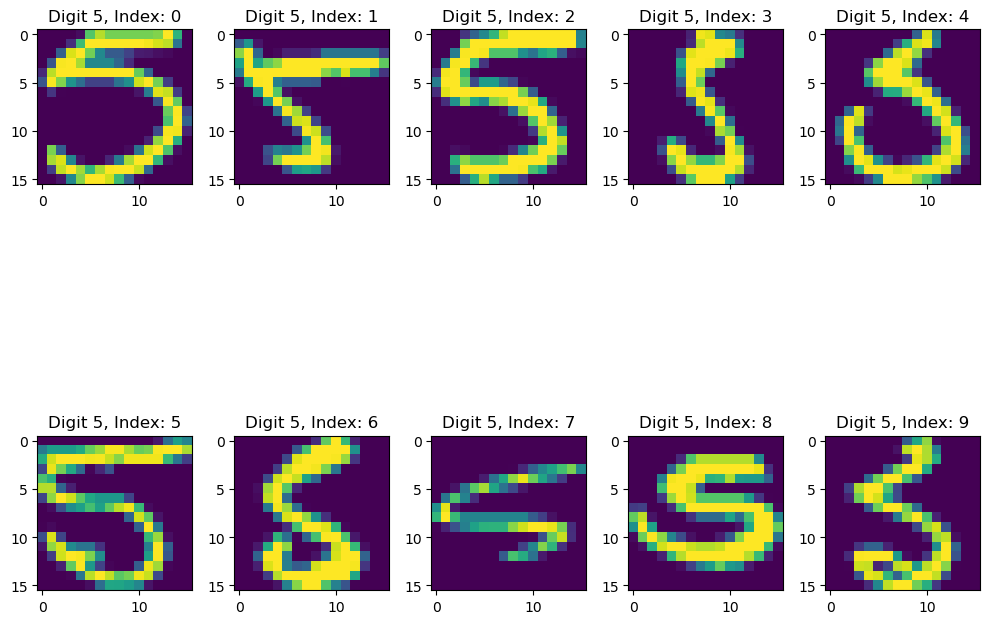

In [14]:
PlotUtils.digit_grid(5, test_X, test_y)

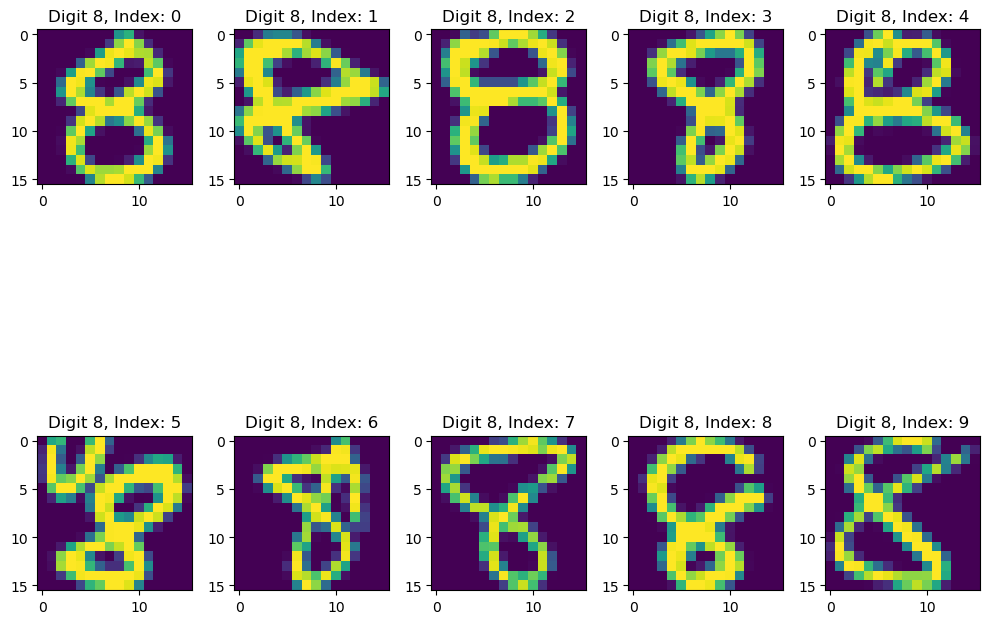

In [15]:
PlotUtils.digit_grid(8, test_X, test_y)

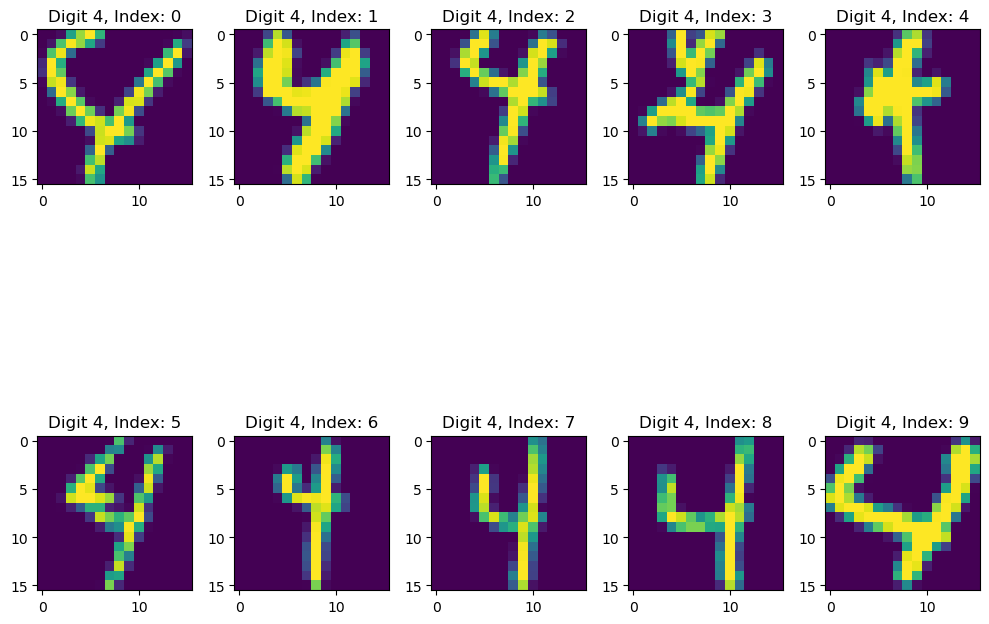

In [16]:
PlotUtils.digit_grid(4, test_X, test_y)

**Remarks**

It can be seen that these classes contain badly written digits, especially the class 5 digits as some look like the letter `S`, or even as a `3` or `6`

### 3. Checking the singular values of the different classes (to identify where fewer components can be used)

**Methodology**

Construct a table (for n_components=5) in order to inspect the singular values per class digit.\
Identify if fewer components can be used for certain digits.\
Verify this by fitting (on train set) and evaluating (on test set) for the selected classes.

In [17]:
def singular_values_df(train_X, train_y, n_components=5):
    labels = np.unique(train_y)
    svd_classifier = SVDClassifier(k = [n_components]).fit(train_X, train_y)

    singular_values = np.zeros((len(labels), n_components))
    for i in range(len(labels)):
        singular_values[i] = svd_classifier.digit_extractors[i].singular_values

    column_names = [r"$\lambda_{}$".format(idx+1) for idx in range(n_components)]
    column_names.insert(0, 'Digit')

    df = pd.DataFrame(columns=column_names)

    for i in range(len(labels)):
        series = [i] + list(singular_values[i])
        df.loc[len(df)] = series

    return df

In [18]:
singular_values_df(train_X, train_y, n_components = 5)

,Digit,$\lambda_1$,$\lambda_2$,$\lambda_3$,$\lambda_4$,$\lambda_5$
0,0.0,184.447498,97.593884,62.050613,54.149312,41.060201
1,1.0,234.041517,41.930906,24.849243,16.294807,13.610955
2,2.0,138.283700,57.397394,46.395696,40.960031,37.505307
3,3.0,126.638236,39.773673,33.322457,29.873724,27.964630
4,4.0,123.027065,41.626024,34.934312,32.290758,26.811828
5,5.0,94.284126,37.852991,35.774941,28.020672,24.046663
6,6.0,141.959617,52.194661,37.965846,32.014514,26.285055
7,7.0,160.196984,46.710359,36.525125,34.687637,31.495607
8,8.0,133.067806,41.643537,34.459963,30.495632,28.716664
9,9.0,141.223909,45.725127,30.058437,29.457084,22.934433


From the table above we can see that class `1` has a very large $\lambda_1$ value compared to the other classes.\
Also the gap between $\lambda_1$ and $\lambda_2$ is quite large.\
These facts indicate that for class `1`. It might be sufficient to only use $k=1$ to represent the digit `1`.\
Lets verify this below.

In [19]:
# Fit all class digits with 5 components except class 1 where we use 1 component
svd_classifier = SVDClassifier(k=[5,1,5,5,5,5,5,5,5,5]).fit(train_X, train_y)
predictions = svd_classifier.predict(test_X)
report = PlotUtils.classification_report(test_y, predictions)

report

,precision,recall,f1-score,support
0,0.931034,0.977716,0.953804,359.000000
1,0.991903,0.928030,0.958904,264.000000
2,0.930851,0.883838,0.906736,198.000000
3,0.852071,0.867470,0.859701,166.000000
4,0.853535,0.845000,0.849246,200.000000
5,0.845161,0.818750,0.831746,160.000000
6,0.888889,0.941176,0.914286,170.000000
7,0.867089,0.931973,0.898361,147.000000
8,0.899329,0.807229,0.850794,166.000000
9,0.865591,0.909605,0.887052,177.000000


**Remarks**

It can be seen from a previous table, that when `n_components=5` is used for class digit `1` the reported F1-score is 0.960302\
From the table above, it can be seen that when `n_components=1` is used for class digit `1` the reported F1-score is 0.958904\
These scores are very close, which indicates that for class 1 it pays off to use only 1 component (instead of 5)

Lets perform another experiment where for class `0` we use 3 components instead of 5.

In [20]:
# Fit all class digits with 5 components
# except class 0 where 3 components are used.
svd_classifier = SVDClassifier(k=[3,5,5,5,5,5,5,5,5,5]).fit(train_X, train_y)
predictions = svd_classifier.predict(test_X)
report = PlotUtils.classification_report(test_y, predictions)

report

,precision,recall,f1-score,support
0,0.976540,0.927577,0.951429,359.000000
1,0.958491,0.962121,0.960302,264.000000
2,0.926316,0.888889,0.907216,198.000000
3,0.834286,0.879518,0.856305,166.000000
4,0.869792,0.835000,0.852041,200.000000
5,0.817073,0.837500,0.827160,160.000000
6,0.879781,0.947059,0.912181,170.000000
7,0.861635,0.931973,0.895425,147.000000
8,0.887417,0.807229,0.845426,166.000000
9,0.860963,0.909605,0.884615,177.000000


**Remarks**

It can be seen from a previous table, that when `n_components=5` is used for class digit `0` the reported F1-score is 0.953804\
From the table above, it can be seen that when `n_components=3` is used for class digit `0` the reported F1-score is 0.951429\
These scores are very close, which indicates that for class `0` it pays off to use only 3 components (instead of 5)

## Optional Tasks

### Two stage algorithm with SVD

**Methodology**

In this section the class `TwoStageSVDClassifier` is implemented in order to reflect the variant required.\
By the exercise, for an uknown digit use only the first singular vector of each class and classify to the class whose
residual is significantly smaller than the others'.\
If this is not satisifed proceed with using all singular vectors.
Compute how frequently the second stage is used and compute the accuracy of this variant.

Note: For the "significantly smaller" part the relative diff is calculated with a threshold of 0.4 (meaning 40%)

In [21]:
class TwoStageSVDClassifier:
    def __init__(self, k=[5], n_iter=10, seed=seed):
        self.k = k
        self.n_iter = n_iter
        self.seed = seed

        # Per digit-class extractor using SVD
        self.digit_extractors = {}

    def fit(self, X, y):
        """ Fit on images.

        Extracts singular vectors and values per class/digit.
        """
        # Get the unique labels/digits
        y_unique = np.unique(y)

        # Replicate the number of components to use for every class
        if len(self.k) == 1:
            k_values = np.array(self.k * len(y_unique))
        else:
            k_values = np.array(self.k)

        for class_digit in y_unique:
            indices = (y == class_digit)
            class_images = X[indices]

            extractor = DigitSVDExtractor(class_digit, k=k_values[class_digit],
                                          n_iter=self.n_iter, seed=self.seed)
            extractor.fit(class_images)
            self.digit_extractors[class_digit] = extractor

        return self

    def predict(self, dataset_X, threshold=0.4):
        """ Predict on images.

        Returns a predicted class/digit per given image.
        """
        predicted_digits = []
        n_second_stage = 0

        for i in range(len(dataset_X)):
            test_image = dataset_X[i]

            predicted_digit = self._first_stage(test_image, threshold)

            if predicted_digit is None:
                # Unsuccessful first stage, enter the second stage
                n_second_stage += 1

                # Second stage: Using all singular vectors
                predicted_digit = self._second_stage(test_image)

            # Append the prediction
            predicted_digits.append(predicted_digit)

        predicted_digits = np.array(predicted_digits)

        return (predicted_digits, n_second_stage)

    def _first_stage(self, test_image, threshold):
        class_residuals = []

        for class_digit in list(self.digit_extractors.keys()):
            relative_residual = self.digit_extractors[class_digit].relative_residual(
                test_image, use_only_first=True)
            class_residuals.append(relative_residual)
        
        for i in range(len(class_residuals)):
            # check if class i is significantly smaller than the others
            residual_of_class_i = class_residuals[i]
            significantly_smaller = []

            for j in range(len(class_residuals)):
                if j != i:
                    residual_of_class_j = class_residuals[j]
                    if residual_of_class_i < residual_of_class_j:
                        if (np.abs(residual_of_class_i - residual_of_class_j) / residual_of_class_j) >= threshold:
                            significantly_smaller.append(True)
                        else:
                            significantly_smaller.append(False)
                    else:
                        significantly_smaller.append(False)

            # Check if all elements are True, meaning that the residual of class i is
            # significantly smaller than the others
            if all(significantly_smaller):
                return i

        return None

    def _second_stage(self, test_image):
        class_residuals = []

        for class_digit in list(self.digit_extractors.keys()):
            relative_residual = self.digit_extractors[class_digit].relative_residual(
                test_image, use_only_first=False)
            class_residuals.append(relative_residual)

        class_residuals = np.array(class_residuals)

        # predict the digit by selecting the class with the smallest relative residual
        return np.argmin(class_residuals)

    def evaluate(self, dataset_X, dataset_y, threshold=0.4):
        """ Calculates accuracy on a given dataset. """
        (predicted_digits, n_second_stage) = self.predict(dataset_X, threshold)
        accuracy = (predicted_digits == dataset_y).sum() / len(dataset_y)

        return (accuracy, predicted_digits, n_second_stage)

In [22]:
svd_classifier = TwoStageSVDClassifier(k=[5]).fit(train_X, train_y)
(accuracy, predictions, n_second_stage) = svd_classifier.evaluate(test_X, test_y)

n_first_stage = len(predictions) - n_second_stage
n_first_stage_percent = n_first_stage / len(test_y)

n_second_stage_percent = n_second_stage / len(test_y)

print("Accuracy: {}".format(accuracy))
print("=======================")
print("Successful First Stage:")
print("Test samples: {} - Percentage: {}".format(n_first_stage, n_first_stage_percent))
print('=======================')
print("[Fallback- Using all singular vectors] Second Stage:")
print("Test samples: {} - Percentage: {}".format(n_second_stage, n_second_stage_percent))

Accuracy: 0.9028400597907325
Successful First Stage:
Test samples: 250 - Percentage: 0.1245640259093174
[Fallback- Using all singular vectors] Second Stage:
Test samples: 1757 - Percentage: 0.8754359740906826


**Remarks**

This variant does not work well.\
The accuracy of course does not change (due to the fallback stage), but around 87.5% of the time the first stage does not work and the second stage comes to the rescue.\
Again, the threshold used is 0.4 regarding the significantly smaller.